# Dynamic Hess Model

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from pylops.utils.wavelets import ricker
from pylops.avo.poststack import PoststackLinearModelling
from strainprox.utils import *
from pylops import CausalIntegration
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('/ibex/user/romerojd/strainprox')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


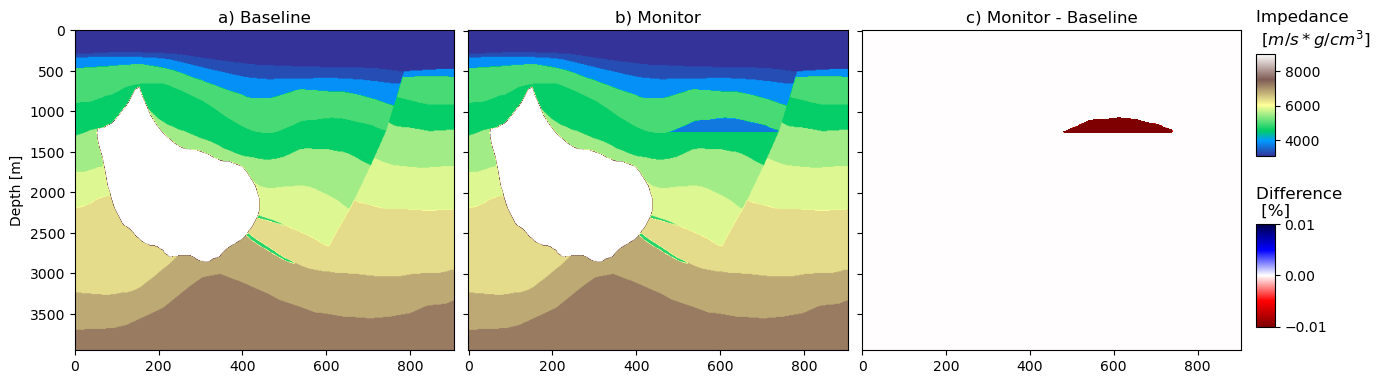

In [21]:
# Loading the data 
hess4d = np.load('data/Hess/Hess4d.npz')
v1 = hess4d['v_base'].astype('float32') # Baseline velocity model
v2 = hess4d['v_mon'].astype('float32')  # Monitor velocity model
rho = 2. # Density

dims = v1.shape

# Calculate base and monitor impedance
m1 = v1 * rho # Baseline impedance
m2 = v2 * rho # Monitor impedance

# Depth sampling
dz = 10

# Plot the data
plotter_4D(m1, m2, dt=dz, ztitle='Depth [m]')

## Time-conversion

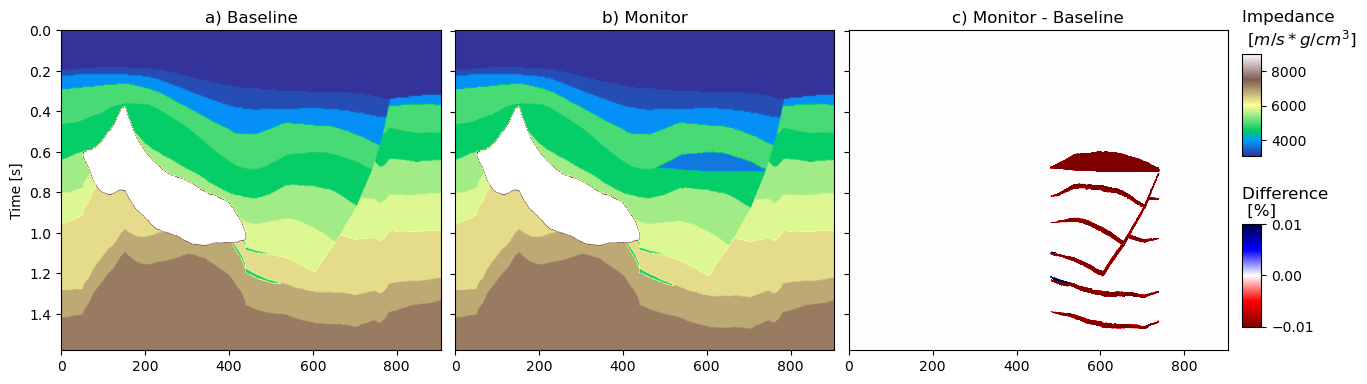

In [14]:
nt, nx = m1.shape
dt = 0.004 # time sampling
t = np.arange(0, nt*dt, dt) # time axis

C = CausalIntegration(dims=v1.shape, axis=0, sampling=dz, dtype='float32') # sampling is the depth sampling (10 m)

t_axis = C * (1/ v1)  # sum of the inverse of velocities
v1t = np.empty(v1.shape, dtype='float32')
for i in range(v1.shape[1]):
    f = interp1d(t_axis[:, i], v1[:, i],  fill_value='extrapolate')
    v1t[:, i] = f(t)

# Monitor time conversion
t_axis2 = C * (1 / v2)  # sum of the inverse of velocities
v2t = np.empty(v2.shape, dtype='float32')
for i in range(v2.shape[1]):
    f = interp1d(t_axis2[:, i], v2[:, i],  fill_value='extrapolate')
    v2t[:, i] = f(t)

# Base and monitor impedance in time
m1t = v1t * rho
m2t = v2t * rho

plotter_4D(m1t, m2t, dt=dt, ztitle='Time [s]')

In [15]:
# Seismic Modeling

ntwav=61
wav, twav, wavc = ricker(t[:ntwav // 2 + 1], 16)
Lop = PoststackLinearModelling(wav / 2, nt0=nt, spatdims=nx)
d1 = Lop * np.log(m1t)
d2 = Lop * np.log(m2t)

sigman = 5e-2
n1 = filtfilt(np.ones(10) / 10, 1,
             filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt, nx)).T, method='gust').T,
             method='gust')

n2 = filtfilt(np.ones(10) / 10, 1,
             filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt, nx)).T, method='gust').T,
             method='gust')
dn1 = d1 + n1
dn2 = d2 + n2

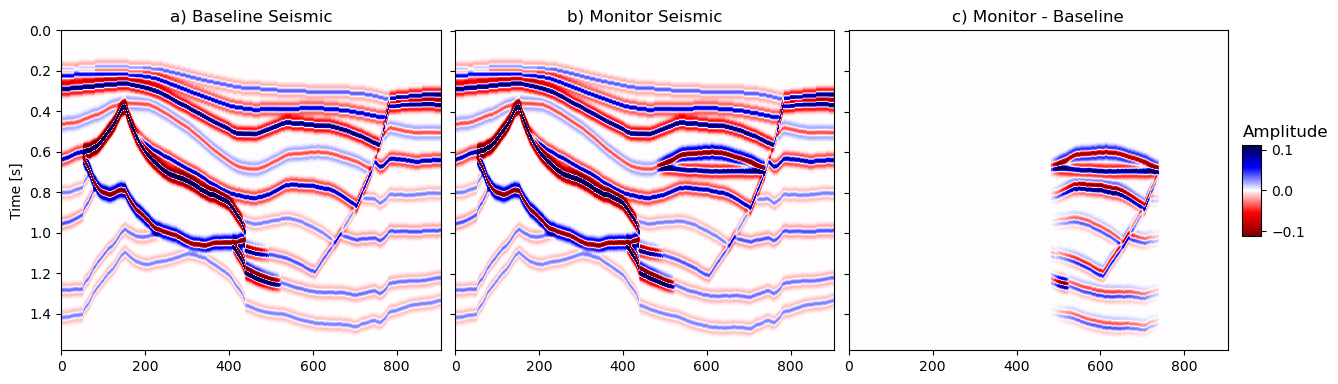

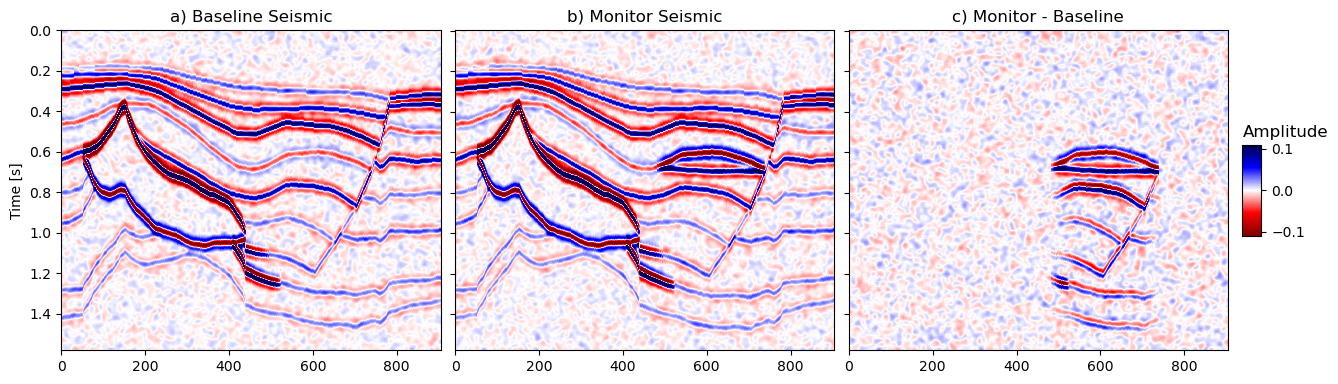

In [16]:
plotter_4D(d1, d2, dt=dt, ztitle='Time [s]', type='seismic')
plotter_4D(dn1, dn2, dt=dt, ztitle='Time [s]', type='seismic')

# Adding time-shift to the baseline data

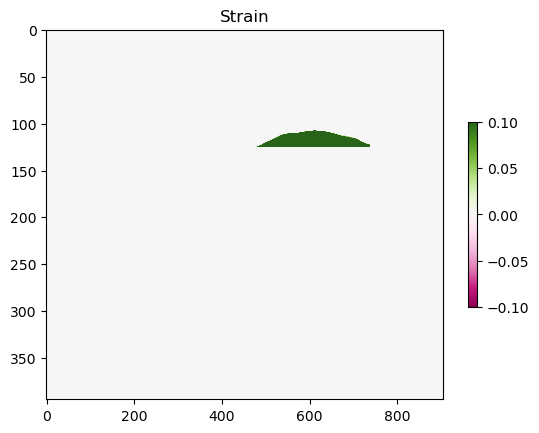

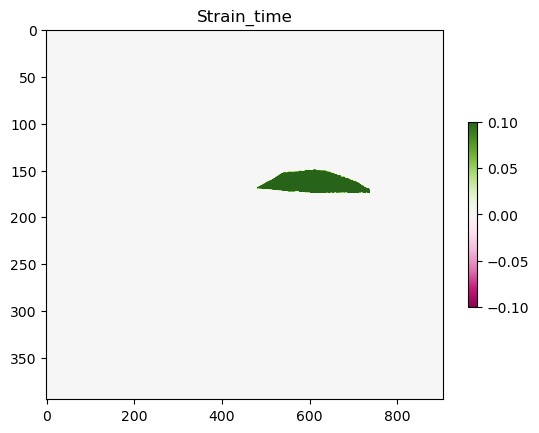

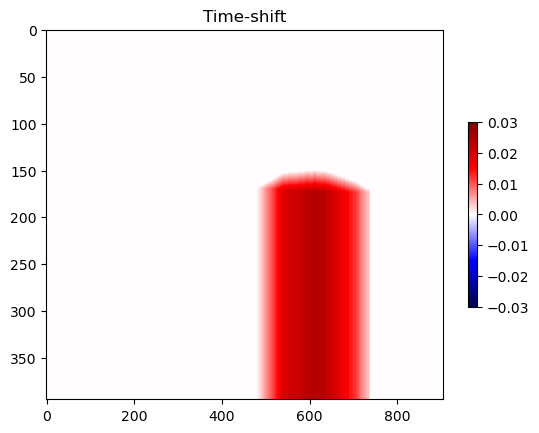

In [17]:
strain = -(v2-v1)/v2 # strain in depth

# Strain convertion to time
strain_t = np.empty(v2.shape)
for i in range(v2.shape[1]):
    f = interp1d(t_axis2[:, i], strain[:, i],  fill_value='extrapolate')
    strain_t[:, i] = f(t)

# Time shift calculation
C = CausalIntegration(dims=v1.shape, axis=0, sampling=dt, dtype='float32')
time_shift = C * strain_t

tshift = t[:, np.newaxis] + time_shift
d2s = np.empty(d1.shape)
for i in range(nx):
    f = interp1d(tshift[:,i], d1[:, i], fill_value='extrapolate')
    d2s[:, i] = f(t)
  
plt.imshow(strain, cmap='PiYG', vmin=-0.1, vmax=0.1)
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plt.imshow(strain_t, cmap='PiYG', vmin=-0.1, vmax=0.1)
plt.title('Strain_time')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plt.imshow(time_shift, cmap='seismic', vmin=-0.03, vmax=0.03)
plt.title('Time-shift')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()

Pure time-shift modeling

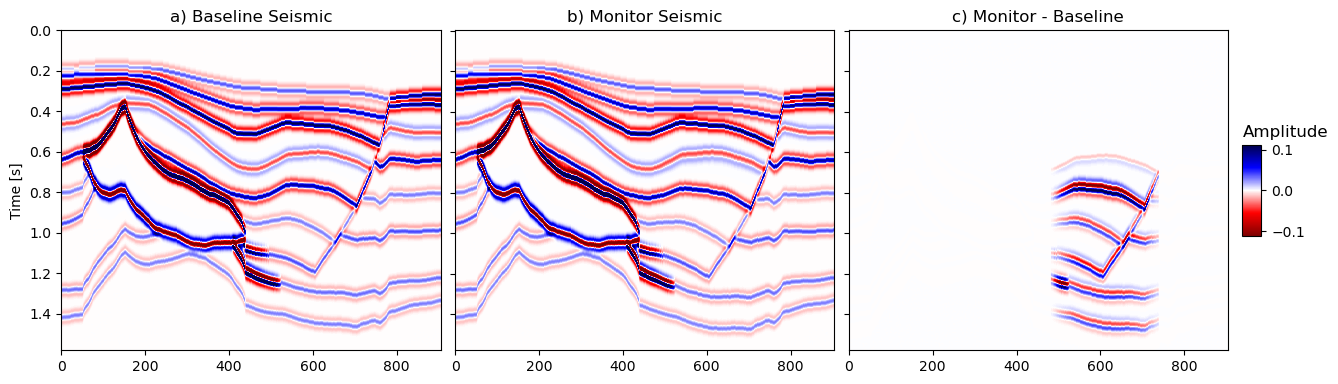

In [18]:
plotter_4D(d1, d2s, dt=dt, ztitle='Time [s]', type='seismic')

Time-shift with amplitude changes modeling

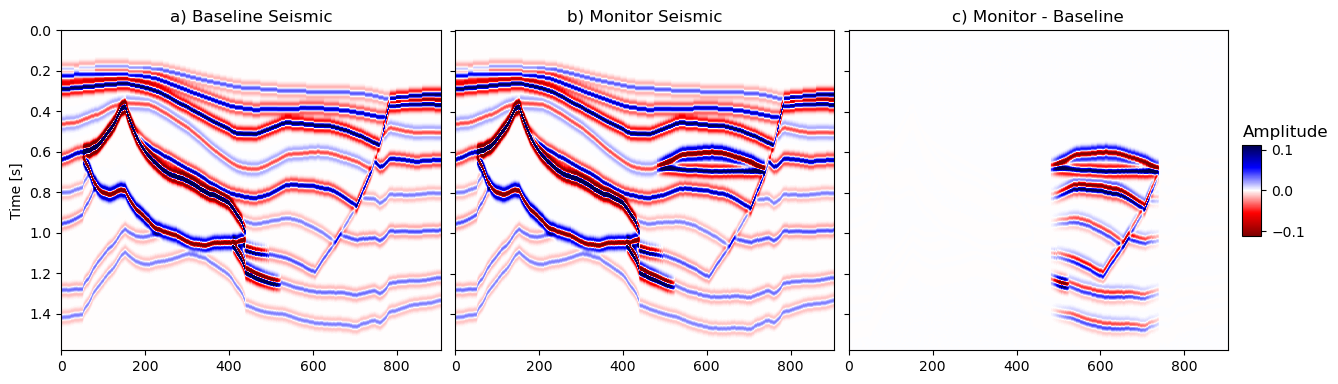

In [19]:
## Accounting for amplitude changes:
d2f = d2s + Lop*-strain_t
plotter_4D(d1, d2f, dt=dt, ztitle='Time [s]', type='seismic')

Time-shift from the depth conversion shown earlier:

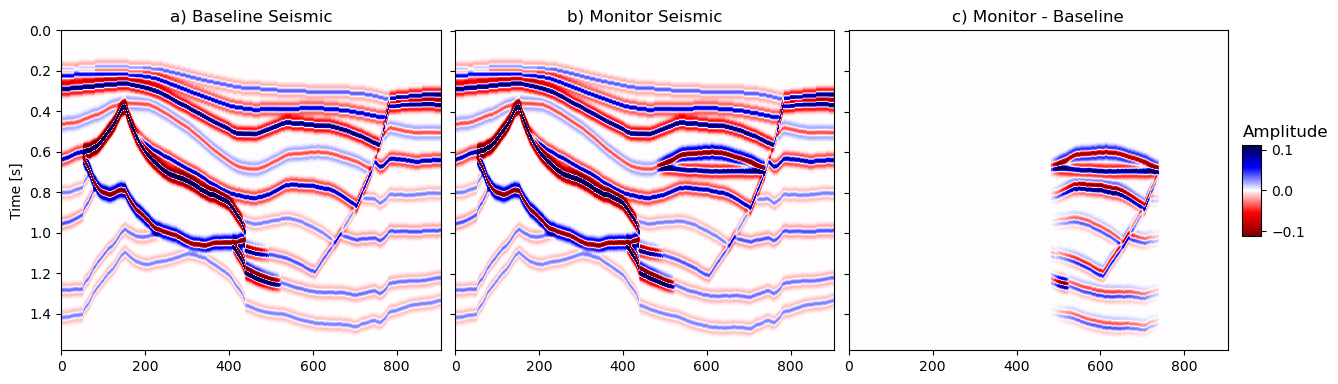

In [20]:
plotter_4D(d1, d2, dt=dt, ztitle='Time [s]', type='seismic')

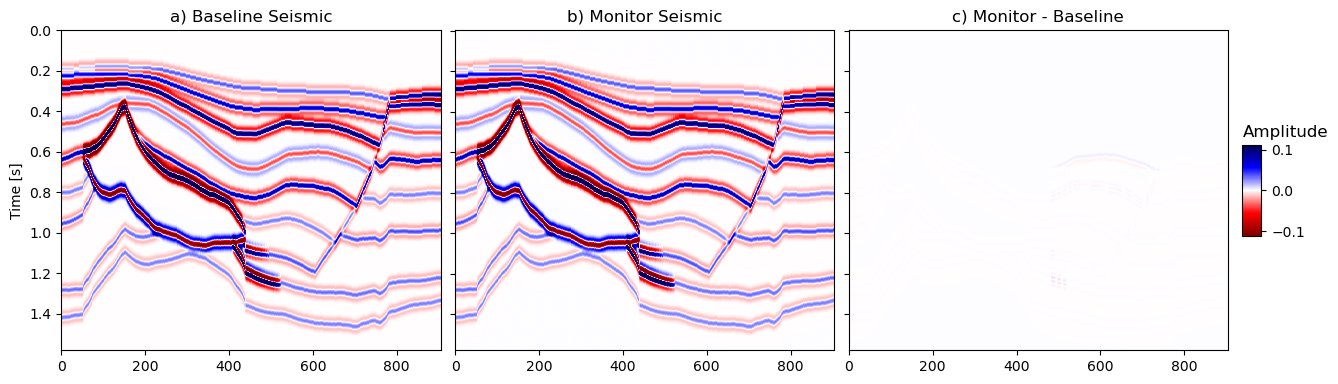

In [23]:
## Removing the shift:
d2i = np.empty(d1.shape)
interpolators = [
    interp1d((t[:, np.newaxis] - time_shift)[:,col], d2s[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2s.shape[1])
]

for col, interpolator in enumerate(interpolators):
    d2i.reshape(dims)[:, col] = interpolator(t)
    
plotter_4D(d1, d2i, dt=dt, ztitle='Time [s]', type='seismic')

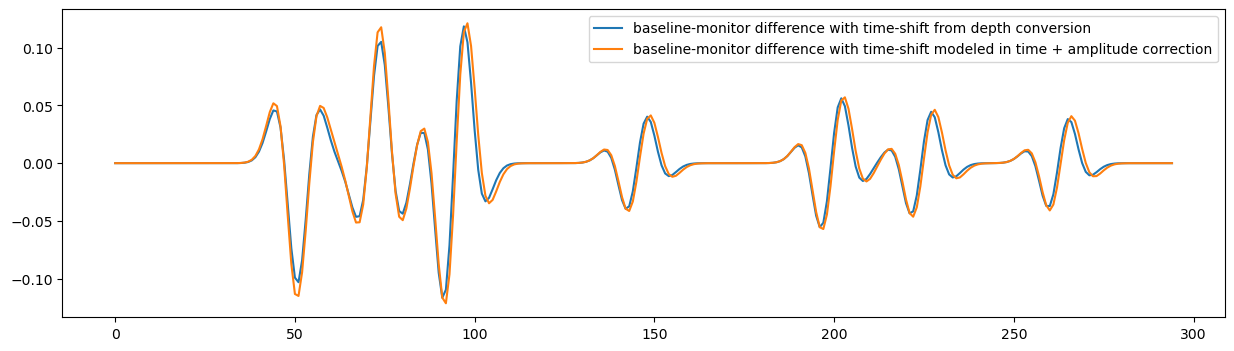

In [98]:
plt.figure(figsize=(15, 4))
plt.plot((d2-d1)[100:,600], label='baseline-monitor difference with time-shift from depth conversion')
plt.plot((d2f-d1)[100:,600], label='baseline-monitor difference with time-shift modeled in time + amplitude correction')
plt.legend()

In [27]:
# Save the time-strain model data to a .npz file
np.savez('data/Hess/Hess4d_time.npz', 
         m1t=m1t, m2t=m2t, # baseline and monitor impedance models in time
         dn1=dn1, dn2=dn2, # baseline and monitor seismic data with noise
         d1=d1, d2=d2,
         straint=strain_t,
         wav=wav) # noise-free seismic data